<a href="https://colab.research.google.com/github/hseyeon1006/ESAA_OB/blob/%ED%95%84%EC%82%AC/Chap7_HW0918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온 7장 앙상블 학습과 랜덤 포레스트 p. 245-271

#Chapter7. 앙상블 학습과 랜덤 포레스트

##7.1. 투표 기반 분류기

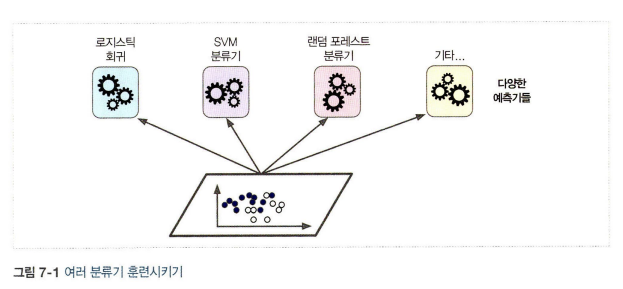

더 좋은 분류기를 만드는 매우 간단한 방법 : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 -> 다수결 투표로 정해지는 분류기를 직접 투표 분류기라고 함

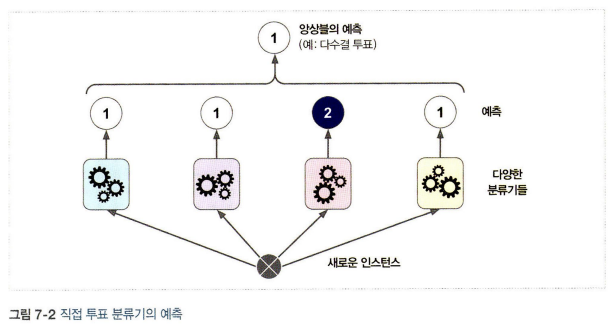

이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음

각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음

큰 수의 법칙 : 더 많이 던질수록 확률이 증가함

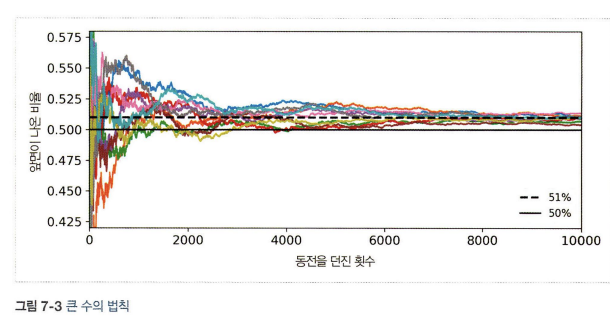

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import package
import numpy as np
import os

In [ ]:
#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#여러 분류기를 조합하여 사이킷런의 투표 기반 분류기를 만들고 훈련시키기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.9
SVC 0.85
VotingClassifier 0.85


-> 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음

간접 투표 : 모든 분류기가 클래스의 확률을 예측할 수 있으면, 개별 분류기의 예측을 평균을 내어 확률이 가장 높은 클래스를 예측할 수 있음

이 방식은 확률이 높은 투표에 더 비중을 두기 때문에 직접 투표 방식보다 성능이 높음

##7.2. 배깅과 페이스팅

* 배깅 : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
* 페이스팅 : 중복을 허용하지 않고 샘플링하는 방식

-> 배기오가 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있음

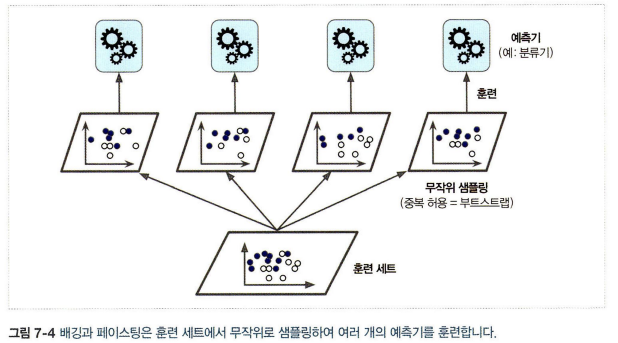

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦

수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산함

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함

일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

###7.2.1. 사이킷런의 배깅과 페이스팅

In [ ]:
#결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
#각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Note) BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 직접 투표 대신 자동으로 간접 투표 방식을 사용함

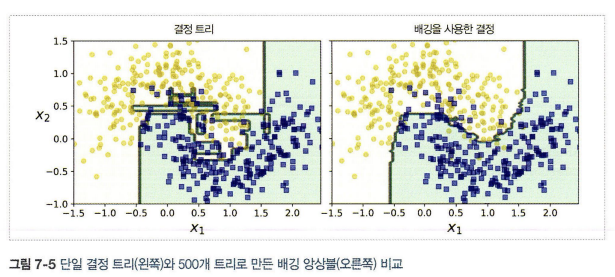

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음

하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴

전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함

하지만 CPU 파워와 시간적 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 나은 쪽을 선택하는 것이 나음

###7.2.2. obb 평가

In [ ]:
#oob 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

#평가 점수 결과
bag_clf.oob_score_

0.9375

In [ ]:
#테스트 세트에서 정확도 (실제 정확도)
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [ ]:
#obb 샘플에 대한 결정 함수의 값 확인 _ 결정함수는 각 훈련 샘플의 클래스 확률을 반환
bag_clf.oob_decision_function_

array([[0.11111111, 0.88888889],
       [0.3626943 , 0.6373057 ],
       [0.82022472, 0.17977528],
       [0.37078652, 0.62921348],
       [0.27717391, 0.72282609],
       [0.98837209, 0.01162791],
       [0.19662921, 0.80337079],
       [0.90322581, 0.09677419],
       [0.99411765, 0.00588235],
       [0.95811518, 0.04188482],
       [0.1627907 , 0.8372093 ],
       [0.00529101, 0.99470899],
       [0.        , 1.        ],
       [0.97409326, 0.02590674],
       [0.        , 1.        ],
       [0.05232558, 0.94767442],
       [1.        , 0.        ],
       [0.81725888, 0.18274112],
       [0.        , 1.        ],
       [0.99481865, 0.00518135],
       [0.57142857, 0.42857143],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.93617021, 0.06382979],
       [0.        , 1.        ],
       [0.98305085, 0.01694915],
       [0.56372549, 0.43627451],
       [1.        , 0.        ],
       [0.16756757, 0.83243243],
       [0.

##7.3. 랜덤 패치와 랜덤 스페이스

랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

-> 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

##7.4. 랜덤 포레스트

In [ ]:
#500개 트리로 이뤄진 랜덤포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
#BaggingClassifier을 RandomforestClassifier와 비슷하게 구현
bag_clf=BaggingClassifier(DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
                          n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

###7.4.1. 엑스트라 트리

익스트림 랜덤 트리 (엑스트라 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트. 편향이 늘어나지만 분산을 낮추게 됨. 랜덤포레스트보다 속도가 훨씬 빠름

###7.4.2. 특성 중요도

랜덤 포레스트의 장점 : 특성의 상대적 중요도를 측정하기 쉬움

사이킷런 : 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함. 즉, 가중치 평균이며 각 노드의 가중치는 연관된 훈련된 샘플수와 같음

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.094156459810849
sepal width (cm) 0.02388641766417243
petal length (cm) 0.4265948426880791
petal width (cm) 0.4553622798368995


MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 시각화

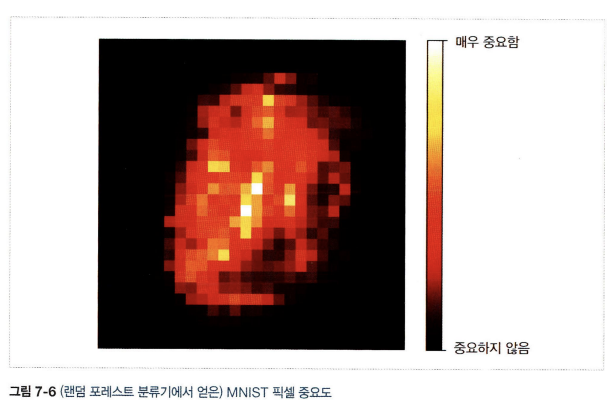

##7.5. 부스팅

부스팅 : 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법

부스팅의 아이디어 : 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것

###7.5.1. 에이다부스트

사용 방식 : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임으로써 새로운 예측기는 학습하기 어려운 샘플에 점점 맞춰지게 됨

예시) 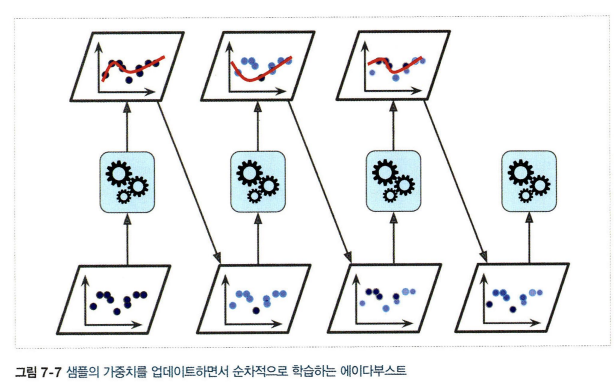

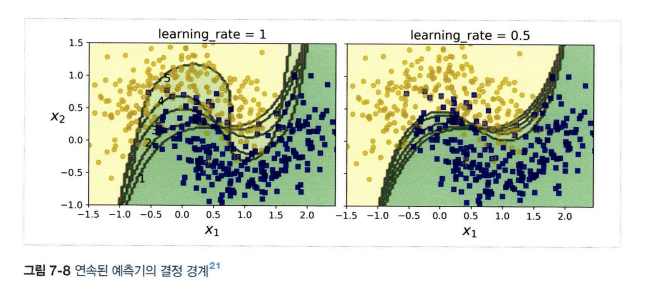


첫번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌음

두번째 분류기는 이 샘플들을 더 정확히 예측하게 됨

오른쪽 그래프를 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것

모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦

하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

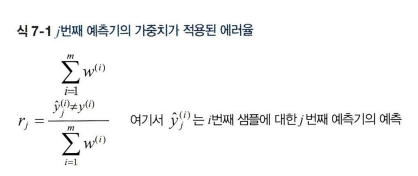

에타 : 학습률 하이퍼파라미터

예측기가 정확할수록 가중치가 높아짐. 만약 무작위로 예측하는 정도라면 가중치가 0에 가까워지고 그보다 나쁘면 가중치는 음수가 됨

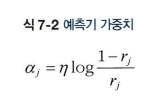

에이다부스트 알고리즘이 샘플의 가중치를 업데이트함

이때 사용하는 식:

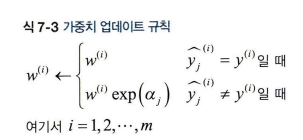

그런 다음 모든 샘플의 가중치를 정규화함

마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됨

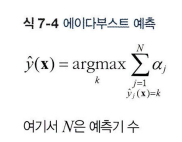

In [14]:
#AdaBoostClassifier의 기본 추정기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

###7.5.2. 그래디언트 부스팅

그래디언트부스팅 : 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함. 하지만 에이다부스트와는 달리 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [21]:
# 데이터 저장
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [22]:
#DT를 훈련세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [23]:
#첫번째 예측기에서 생긴 잔여 오차에 두번째 DT를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [24]:
#두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [25]:
# 테스트셋 생성
X_new = np.array([[0.8]])

In [26]:
#새로운 샘플에 대한 예측 -> 모든 트리의 예측 더하기
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [27]:
#이전에 만든 것과 같은 앙상블을 만드는 코드
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=1)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=1)

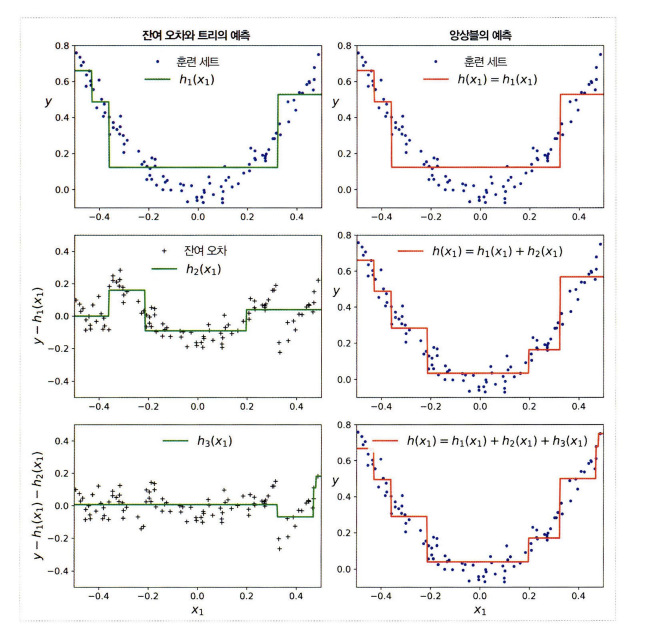

왼쪽 열 : DT의 예측 / 오른쪽 열 : 앙상블의 예측

첫번째 행 : 앙상블의 트리가 하나만 있어서 첫번째 트리의 예측과 완전히 같음

두번째 행 : 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습됨. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 확인

세번째 행 : 또 다른 트리가 두번째 트리의 잔여 오차에 훈련됨. 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐

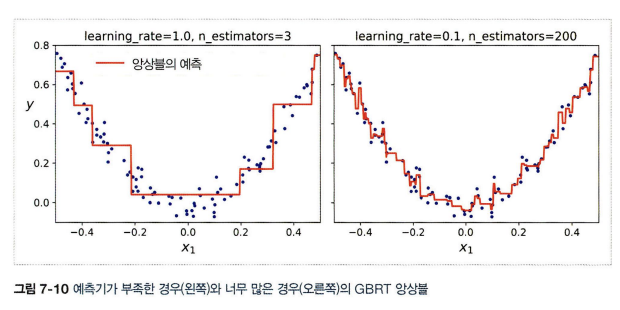

learning_rate를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐 -> 축소라고 부르는 규제 방식

왼쪽 : 훈련 세트를 학습하기에는 트리가 불충분

오른쪽 : 트리가 너무 많아 훈련 세트에 과대적합

In [28]:
#120개의 트리로 GBRT 앙상블 훈련시키고 최적의 트리수 찾기
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=1)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

#최적의 트리 수를 사용해 새로운 GBRT 앙상블 훈련
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=1)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=78, random_state=1)

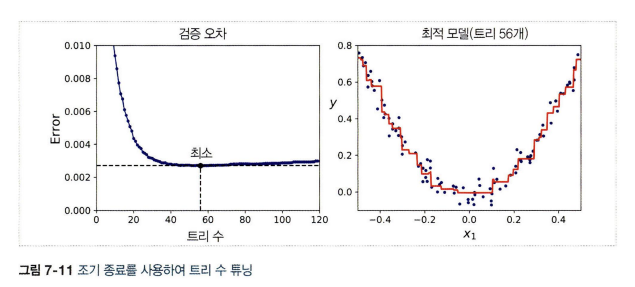

좌 : 검증 오차 / 우 : 최적 모델의 예측

In [29]:
#연속해서 다섯번의 반복동안 검증 오차가 향상되지 않으면 훈련 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=1)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

GB는 각 트리가 훈련할 때 사용할 훈련 샘프르이 비율을 지정할 수 있는 subsample 매개 변수를 지원함

편향이 높아지는 대신 분산이 낮아지고, 훈련 속도를 상당히 높임 -> 확률적 그래디언트 부스팅

In [30]:
#xgboost
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=1)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
#xgboost -> 자동 조기 종료 기능
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

##7.6. 스태킹

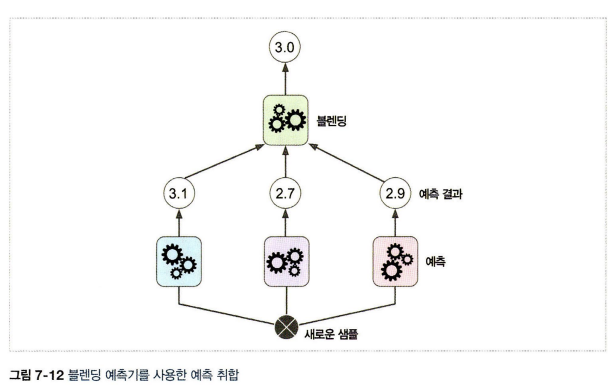

블렌더를 학습시키는 일반적인 방법 : 홀드아웃 세트를 사용하는 것

어떻게 작동하는지??
1. 훈련 세트를 두개의 서브셋으로 나눈다. 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용됨

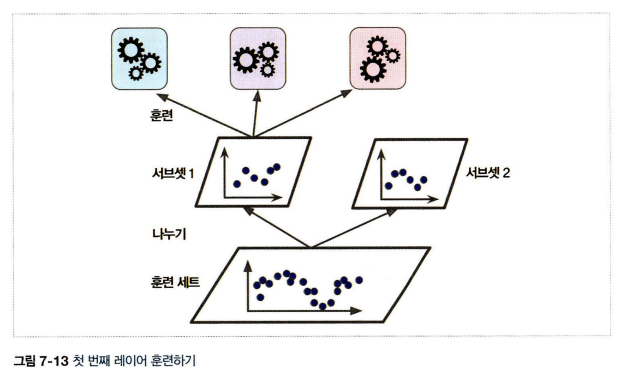

2. 첫번째 레이어의 예측기를 사용해 두번째 (홀드아웃)세트에 대한 예측 만듦. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 새로운 것임

홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있음. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음. 블렌더가 새 훈련세트로 훈련됨. 즉, 첫번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨

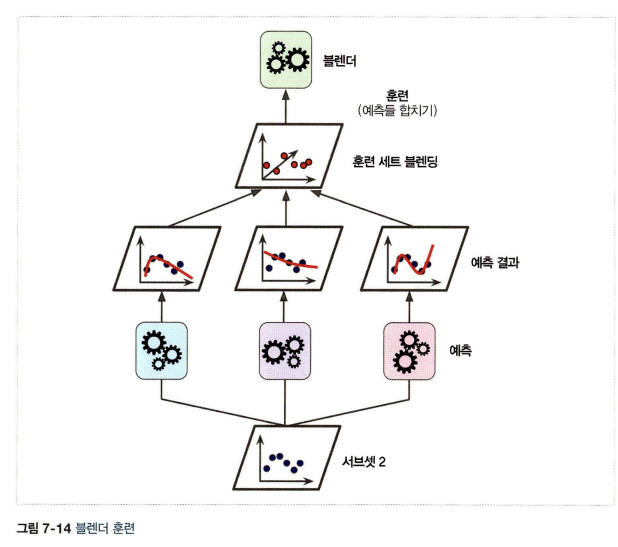

cf) 블렌더를 여러 개 훈련시키는 것도 가능함

ex: 하나는 선형회귀, 다른 하나는 랜덤포레스트회귀

그러면 블렌더만의 레이어가 만들어짐

학습 과정을 반복하면 다음 그림과 같이 각 레이어를 차례로 실행해서 새로운 샘플에 대한 예측을 만들 수 있음

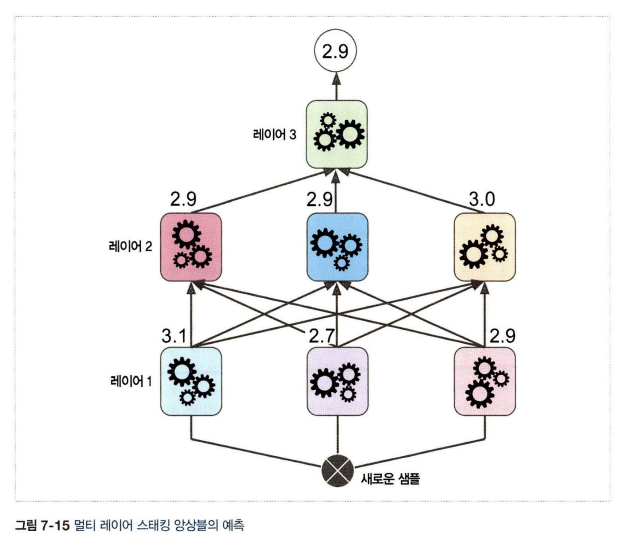